# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:

%load_ext autoreload
%autoreload 2


import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier




## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Fri Feb 23 17:54:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8               3W /  80W |     53MiB /  8188MiB |     34%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "local-bert"

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [5]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Plotting Word Cloud 

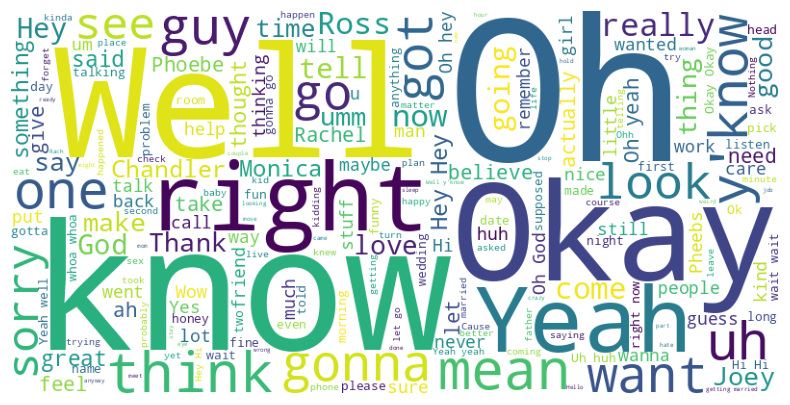

In [30]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [25]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}


### Taking a look to same utterance example

In [8]:
display_dialogue(dataframe=df, utterance_id='utterance_6')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')


Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Removing NaN Values

In [9]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Analyzing the dataset

In [10]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in an utterance: {speakers['min_speakers']}")
print(f"Maximum number of speakers in an utterance: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in an utterance: {utterances['length_min']}")
print(f"Maximum number of sentences in an utterance: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in an utterance: 1
Maximum number of speakers in an utterance: 8

Minimum number of sentences in an utterance: 2
Maximum number of sentences in an utterance: 24


In [11]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Appling some preprocessing operations 

In the following cell, individual utterances constituting a dialogue are concatenated to form a single string while preserving separation through the addition of the token '[SEP]'.

In [12]:
df['processed_utterances'] = df['utterances'].apply(concat_with_sep)
df['processed_utterances']


episode
utterance_0       also I was the point person on my company's tr...
utterance_1       also I was the point person on my company's tr...
utterance_2       also I was the point person on my company's tr...
utterance_3       also I was the point person on my company's tr...
utterance_4       But then who? The waitress I went out with las...
                                        ...                        
utterance_3995    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3996    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3997    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3998    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3999    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
Name: processed_utterances, Length: 4000, dtype: object

### Splitting the dataset 

In [13]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_267,"[Chandler, Chandler]","[joy, neutral]","[That's great., Well, I'm gonna get another es...","[0.0, 0.0]","That's great. [SEP] Well, I'm gonna get anothe..."
utterance_1917,"[Tag, Rachel, Tag, Rachel]","[neutral, neutral, neutral, anger]","[It's not here., Puzzler. A bit of a puzzle. W...","[0.0, 0.0, 1.0, 0.0]",It's not here. [SEP] Puzzler. A bit of a puzzl...
utterance_509,"[Ross, Chandler, Ross, Chandler, Ross, Chandle...","[neutral, neutral, neutral, joy, fear, joy, su...","[Ok, bye. Well, Monica's not coming, it's jus...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","Ok, bye. Well, Monica's not coming, it's just..."
utterance_820,"[Doug, Chandler, Monica, Doug, Chandler, Doug,...","[joy, neutral, neutral, joy, sadness, joy, neu...","[Bing! Ho! And the Bing-ette!, Honey, you reme...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Bing! Ho! And the Bing-ette! [SEP] Honey, you ..."
utterance_3342,"[Casey, Joey, Casey, Chandler, Joey, Chandler,...","[neutral, joy, joy, surprise, neutral, surpris...","[Here you go., Great! All right, so I'll call ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Here you go. [SEP] Great! All right, so I'll c..."


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_885,"[Monica, Julio, Monica, Monica, Julio, Monica,...","[surprise, surprise, anger, neutral, surprise,...","[So! I'm just an empty vase, huh?, What?, Y'kn...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","So! I'm just an empty vase, huh? [SEP] What? [..."
utterance_3304,"[Joey, Ross, Chandler, Chandler, Chandler, Ros...","[surprise, surprise, anger, anger, neutral, fe...","[Mark's a genius!, Why?! How?! How is he a gen...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",Mark's a genius! [SEP] Why?! How?! How is he a...
utterance_3924,"[Tag, Rachel, Tag, Rachel]","[neutral, joy, surprise, neutral]","[I'd better get back to my desk., Okay, you ha...","[0.0, 0.0, 1.0, 0.0]","I'd better get back to my desk. [SEP] Okay, yo..."
utterance_3459,"[Ross, Ross, Ross, Ross, Ross]","[surprise, surprise, surprise, anger, surprise]","[My God!, These pants are burning up!, Oh come...","[0.0, 1.0, 1.0, 1.0, 1.0]",My God! [SEP] These pants are burning up! [SEP...
utterance_2818,"[Ross, Joey, Ross, Joey, Rachel, Joey, Ross, R...","[neutral, surprise, sadness, surprise, surpris...",[Can I ask you something? Have you ever had a ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Can I ask you something? Have you ever had a g...


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_2750,"[Joey, Joey, Joey, Ross, Joey, Ross, Ross, Ros...","[surprise, neutral, neutral, neutral, neutral,...","[Oh, that's what she meant!, You know, if they...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Oh, that's what she meant! [SEP] You know, if ..."
utterance_3238,"[Phoebe, Phoebe, Phoebe, Phoebe, Phoebe, Phoebe]","[neutral, neutral, sadness, neutral, sadness, ...","[Hey., Listen, um..., I'm sorry., : Yeah, um.....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","Hey. [SEP] Listen, um... [SEP] I'm sorry. [SEP..."
utterance_3792,"[Rachel, Chandler, Rachel, Chandler, Rachel, C...","[surprise, neutral, sadness, fear, fear, neutral]","[Its still there!, Mrs. Braverman must be out....","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Its still there! [SEP] Mrs. Braverman must be ...
utterance_2134,"[Monica, Rachel, Monica, Rachel, Monica]","[neutral, neutral, neutral, neutral, surprise]","[Would you ever be a surrogate for anyone?, It...","[0.0, 0.0, 0.0, 1.0, 0.0]",Would you ever be a surrogate for anyone? [SEP...
utterance_3564,"[Monica, Phoebe, Monica, Phoebe, Monica, Phoeb...","[neutral, neutral, anger, neutral, sadness, ne...","[Thank you., Thanks., I can't believe this! Th...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]",Thank you. [SEP] Thanks. [SEP] I can't believe...


### Visualizing the distribution of the emotions over the datasets

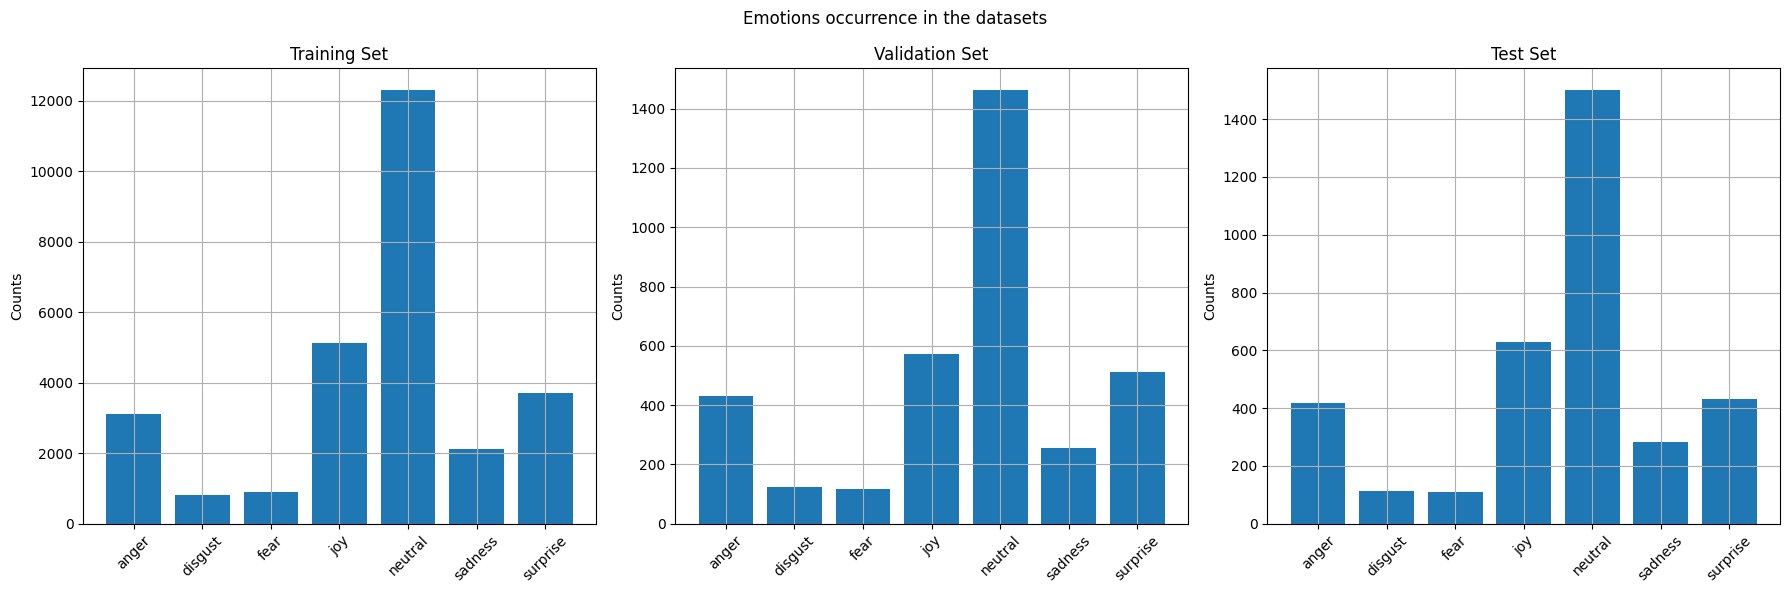

In [14]:
plot_emotion_distribution(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [15]:
from IPython.display import display
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
trigger_weights = create_classes_weights(df['triggers'].sum())

print('Emotion weights')
display(pd.DataFrame({'Emotion': EMOTIONS, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': [0, 1], 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426


Trigger weights


,Trigger,Weight
0,0,0.594761
1,1,3.138206


## Random Classifier

In [24]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.drop(columns='processed_utterances').copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_dialogue(dataframe=new_test_df, utterance_id=0)  


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,surprise,"Oh, that's what she meant!",0.0,fear,1
1,Joey,neutral,"You know, if they're gonna shorten it, they...",0.0,neutral,1
2,Joey,neutral,"You know, short for museum, and avoid all t...",0.0,anger,0
3,Ross,neutral,"Yeah, most of it it's a place",0.0,sadness,1
4,Joey,neutral,"Ok, all right, so I'll take her to the MET.",0.0,surprise,1
5,Ross,neutral,"Yeah, uh, uh, ok, there's this great rare book...",0.0,sadness,1
6,Ross,neutral,You know what?,0.0,sadness,1
7,Ross,neutral,"She loves architecture, you know what you shou...",0.0,joy,0
8,Ross,joy,You should take a walk down fifth to the Saint...,0.0,neutral,1
9,Joey,surprise,"Geez, sounds like you should be going on this ...",1.0,fear,1


## Majority Classifier

In [23]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.drop(columns='processed_utterances').copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_dialogue(dataframe=new_test_df, utterance_id=0)


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,surprise,"Oh, that's what she meant!",0.0,neutral,0.0
1,Joey,neutral,"You know, if they're gonna shorten it, they...",0.0,neutral,0.0
2,Joey,neutral,"You know, short for museum, and avoid all t...",0.0,neutral,0.0
3,Ross,neutral,"Yeah, most of it it's a place",0.0,neutral,0.0
4,Joey,neutral,"Ok, all right, so I'll take her to the MET.",0.0,neutral,0.0
5,Ross,neutral,"Yeah, uh, uh, ok, there's this great rare book...",0.0,neutral,0.0
6,Ross,neutral,You know what?,0.0,neutral,0.0
7,Ross,neutral,"She loves architecture, you know what you shou...",0.0,neutral,0.0
8,Ross,joy,You should take a walk down fifth to the Saint...,0.0,neutral,0.0
9,Joey,surprise,"Geez, sounds like you should be going on this ...",1.0,neutral,0.0


## Bert Models

In [16]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


In [83]:
from typing import Dict
from DrTorch.utilities import DataLoaderFromPipelineStrategy
 
def tokenize_data(data):
    dialog, speakers = data['processed_utterances'], data['speakers']
    tokenizer = BertTokenizer.from_pretrained("local-bert")

    output =  tokenizer.batch_encode_plus(dialog,
                                    return_tensors="pt",
                                    padding=True, 
                                    return_token_type_ids=True)

    return output

def preprocess_labels(labels):
    emotions, triggers = labels['emotions'], labels['triggers']
    encoded_emotions = torch.tensor(pd.get_dummies(emotions).astype(float).values)
    print(emotions[0])
    print('encoded_em',encoded_emotions[0])
    encoded_triggers = None
    output = {'emotions': encoded_emotions,
              'triggers': encoded_triggers}
    
    return output
 
dataLoaderBuilder = DataLoaderFromPipelineStrategy()
dataloader = dataLoaderBuilder.create(train_df[["processed_utterances", "speakers"]].copy(), 
                                      train_df[["emotions", "triggers"]].copy(), 
                                      shuffle=True,
                                      data_preprocess_f=tokenize_data, 
                                      labels_preprocess_f=preprocess_labels,
                                      batch_size=12,
                                      device=device)


for data, label in dataloader:
    print(data['input_ids'][0])
    break
    


['neutral', 'joy', 'neutral', 'surprise', 'neutral', 'joy', 'fear', 'joy', 'joy', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'joy']
encoded_em tensor([0., 1., 0.], dtype=torch.float64)
tensor([  101,  2821,  2026,  2643,   999,   102,  2057,  2657,  2055,  2115,
         6471,  1010,  1045,  1005,  1049,  2061,  3374,  1012,   102,  2023,
         2095,  2001,  4011,  2000,  2022,  2307,   999,   102,  2021,  1010,
         2009,  1005,  1055,  2069,  1996,  2117,  2154,  1998,  1045,  1005,
         1049,  1037, 10916,  2007,  5236,  5898,  6471,  2008,  2123,  1005,
         1056,  2130,  4906,   999,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
 

/tmp/ipykernel_10639/2758368146.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(emotions[0])


In [18]:
dialogs = [
    [
    "also I was the point person on my company's transition from the KL-5 to GR-6 system.",
    "You must've had your hands full.",
    "That I did. That I did.",
    "So let's talk a little bit about your duties.",
    "My duties? All right."
    ],
    ["cacca", "caccona"]
]

tokens = []
for dialog in dialogs:
    tokens.append(construct_input(dialog))

tokens

TypeError: list indices must be integers or slices, not str

In [80]:
import pandas as pd

# Creiamo un DataFrame di esempio
data = {'colonna_lista': [["stringa1", "stringa2", "stringa3"], ["stringa4", "stringa5"], ["stringa6"]]}
df = pd.DataFrame(data)

# Definiamo una funzione per concatenare le stringhe e inserire [SEP] tra di esse
def concat_with_sep(string_list):
    return " [SEP] ".join(string_list)

# Applichiamo la funzione alla colonna del DataFrame e creiamo una nuova colonna
df['colonna_concatenata'] = df['colonna_lista'].apply(concat_with_sep)

# Stampiamo il DataFrame per vedere i risultati
print(df)




                    colonna_lista                     colonna_concatenata
0  [stringa1, stringa2, stringa3]  stringa1 [SEP] stringa2 [SEP] stringa3
1            [stringa4, stringa5]                 stringa4 [SEP] stringa5
2                      [stringa6]                                stringa6


In [42]:
def generate_data_sample(data_dict, idx):
    sample = {}
    for key, value in data_dict.items():
        if isinstance(value, dict):
            sample[key] = generate_data_sample(value, idx)
        else:
            sample[key] = value[idx] if isinstance(value, torch.Tensor) and idx < value.shape[0] else None
    return sample

# Dizionario di esempio
data_dict = {
    'input_ids': {
        'sub_key1': {'prova':{'tensor': torch.tensor([1, 2, 3])}},
        'sub_key2': {'sub_sub_key': {'tensor': torch.tensor([4, 5, 6])}}
    },
    'token_type_ids': torch.tensor([7, 8]),
    'attention_mask': [
        {'tensor': torch.tensor([9, 10, 11])},
        {'tensor': torch.tensor([12, 13, 14])}
    ]
}

# Esempio di utilizzo della funzione con idx = 0
data_sample = generate_data_sample(data_dict, 0)
print(data_sample)

{'input_ids': {'sub_key1': {'prova': {'tensor': tensor(1)}}, 'sub_key2': {'sub_sub_key': {'tensor': tensor(4)}}}, 'token_type_ids': tensor(7), 'attention_mask': None}


In [2]:
import pandas as pd 

# Esempio di una serie con liste di stringhe
serie_pandas = pd.Series([['a', 'b', 'c'], ['d', 'e'], ['f', 'g', 'h']])

# Concatenare tutte le liste di stringhe nella serie
lista_concatenata = serie_pandas.sum()

print(lista_concatenata)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
